# Imports

In [1]:
import os
import numpy as np
from math import ceil

import librosa

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#from scipy.io import wavfile

# Load audio

Características:
* Monocanal
* Frecuencia de muestreo: 22050Hz
* Profundidad: 16bits


In [2]:
SAMPLE_RATE = 22050

# Data prep 

Elijo el tamaño de mis muestras de audio y preparo la matriz a utilizar

In [3]:
SIZE_STFT = 45100 #esto seguramente se pueda calcular pero bue

def doSTFT(data):
    D = librosa.stft(data)
    D = np.abs(D)
    return D.reshape(1, D.shape[0] * D.shape[1] )
    

In [4]:
#doSTFT(matrixAudioDataNoFFT[0]).shape
#matrixAudioDataNoFFT.shape[0]

### Para varios archivos

In [5]:
SEGUNDOS_FILA = 1
SELECCION_DIR = "data/sound/pack/drumkits/"

matrixAudioDataNoFFT = np.empty((0,ceil(SAMPLE_RATE * SEGUNDOS_FILA)), np.int16)
matrixAudioData = np.empty((0, SIZE_STFT), np.float32)

def findMusic(directory):
    musicFiles = []
    
    for file in os.listdir(directory):
        if os.path.isdir(directory + file):
            musicFiles += findMusic(directory + file + "/")
        elif file.endswith(".wav"):
            musicFiles.append( directory + file )
        else:
            if not file.endswith(".asd"):
                print("Skipped:", directory + file)
    
    return musicFiles

audioFiles = findMusic( SELECCION_DIR )

print("")
print("Encontré",len(audioFiles),"archivos de audio")
print("Ahora procesando...")
print("")

count = 0
COUNT_NOTICE = 200

for file in audioFiles:
    try:
        #print(file, end="")
        print(".", end="")

        tmpAudioData, tmpSampleRate = librosa.core.load(file, sr = SAMPLE_RATE)

        tmpAudioData.resize(ceil(SAMPLE_RATE * SEGUNDOS_FILA))
        tmpAudioData = tmpAudioData.reshape(1, ceil(SAMPLE_RATE * SEGUNDOS_FILA))
        matrixAudioDataNoFFT = np.concatenate((matrixAudioDataNoFFT, tmpAudioData), axis = 0 )
        #matrixAudioDataNoFFT = np.stack((matrixAudioDataNoFFT, tmpAudioData), axis=0)

        stft = doSTFT(matrixAudioDataNoFFT[ matrixAudioDataNoFFT.shape[0] - 1 ])
        #print("stft: ", stft.shape)
        #print("Matriz FFT final: ", matrixAudioData.shape)

        matrixAudioData = np.concatenate((matrixAudioData, stft ), axis = 0 )
        #print(" [OK]")
        count += 1

        if count % COUNT_NOTICE == 0:
            print("")
            print("[", count, "/", len(audioFiles), "]")
    except:
        print(file, "[FAIL]")
        
print("")
print("Matriz final: ", matrixAudioDataNoFFT.shape)
print("Matriz FFT final: ", matrixAudioData.shape)

Skipped: data/sound/pack/drumkits/.DS_Store

Encontré 2183 archivos de audio
Ahora procesando...

........................................................................................................................................................................................................
[ 200 / 2183 ]
........................................................................................................................................................................................................
[ 400 / 2183 ]
........................................................................................................................................................................................................
[ 600 / 2183 ]
........................................................................................................................................................................................................
[ 800 / 2183 ]
......................................

# Principal Component Analysis

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=800) #500
pca.fit(matrixAudioData)
print("Variance explained:", pca.explained_variance_ratio_.sum())
matrixAudioDataTransformed = pca.transform(matrixAudioData)
# print(matrixAudioDataTransformed[0])
print("shape transformed:", matrixAudioDataTransformed.shape)

Variance explained: 0.989554999241
shape transformed: (2183, 800)


# Cluster Jerárquico

In [24]:
#matrixAudioDataTransformed = matrixAudioData

In [7]:
from scipy.cluster import hierarchy as h
from scipy.spatial import distance as dist

distanceFunction = 'cosine' #canberra, cityblock, braycurtis, euclidean
linkageType = 'average' #single, complete, weighted, average

distanceMatrix = dist.pdist(matrixAudioDataTransformed, distanceFunction) 
clusters = h.linkage(distanceMatrix, linkageType)


c,d=h.cophenet(clusters, distanceMatrix) #factor cofonético
print("distancia:",distanceFunction)
print("linkage:",linkageType)
print("cofonetica:",c)

distancia: cosine
linkage: average
cofonetica: 0.780956107849


### Dendograma

In [8]:
THRESHOLD = 0.96


cutTree = h.cut_tree(clusters, height= THRESHOLD)
# minutos = 0
# segundos = 0
# for label in cutTree:
#     print(str(minutos) + ":" + str(segundos), str(label))
#     segundos += SEGUNDOS_FILA
#     if ( segundos >= 60 ):
#         minutos += 1
#         segundos -= 60

# print(clusters.shape)
# print(clusters)
# exit()

#matrixAudioDataAndCluster = np.hstack((matrixAudioDataTransformed, cutTree))

cantClusters = np.unique(cutTree).size
print("Cantidad de clusters:", cantClusters)

Cantidad de clusters: 5


<IPython.core.display.Javascript object>


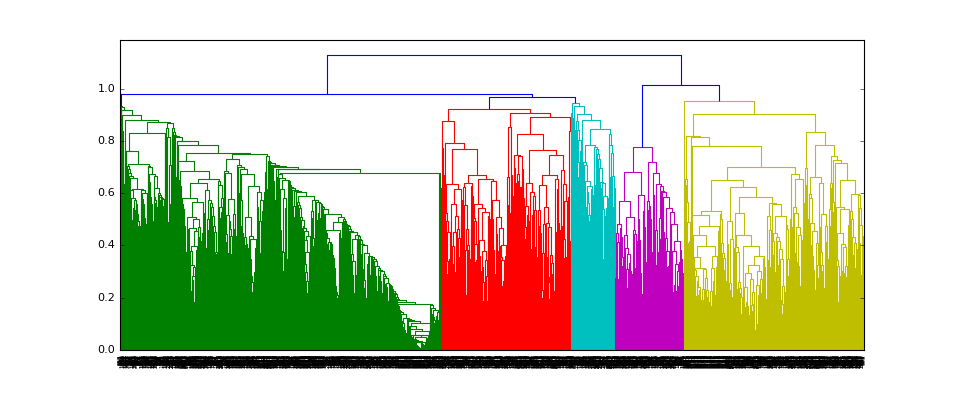

In [190]:
%matplotlib notebook

plt.figure(figsize=(12, 5))
dn = h.dendrogram(clusters, color_threshold = THRESHOLD)
plt.show()

### Histograma

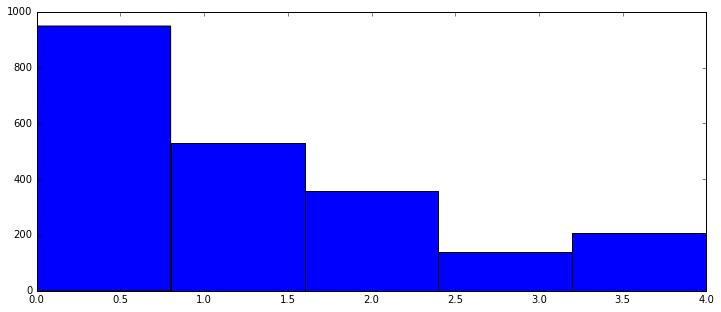

Count:
[ 949.  530.  358.  139.  207.]


In [9]:
%matplotlib inline

plt.figure(figsize=(12, 5))
n = plt.hist(cutTree, bins=cantClusters)[0]
plt.show()
print("Count:")
print(n)

# Multi-dimensional scaling

In [10]:
#check http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html

from sklearn.manifold import MDS 
from sklearn.metrics import pairwise_distances

#similarities = pairwise_distances(matrixAudioDataTransformed, metric = distanceFunction, n_jobs = -1)
similarities = pairwise_distances( dist.squareform(distanceMatrix), n_jobs = -1)

mds = MDS(n_components=2, dissimilarity="precomputed", n_jobs=-1) #max_iter=3000, eps=1e-9, 
positions = mds.fit(similarities).embedding_
#positions = mds.fit(distanceMatrix).embedding_
print("Positions shape:", positions.shape)

Positions shape: (2183, 2)


### Scatterplot

<IPython.core.display.Javascript object>


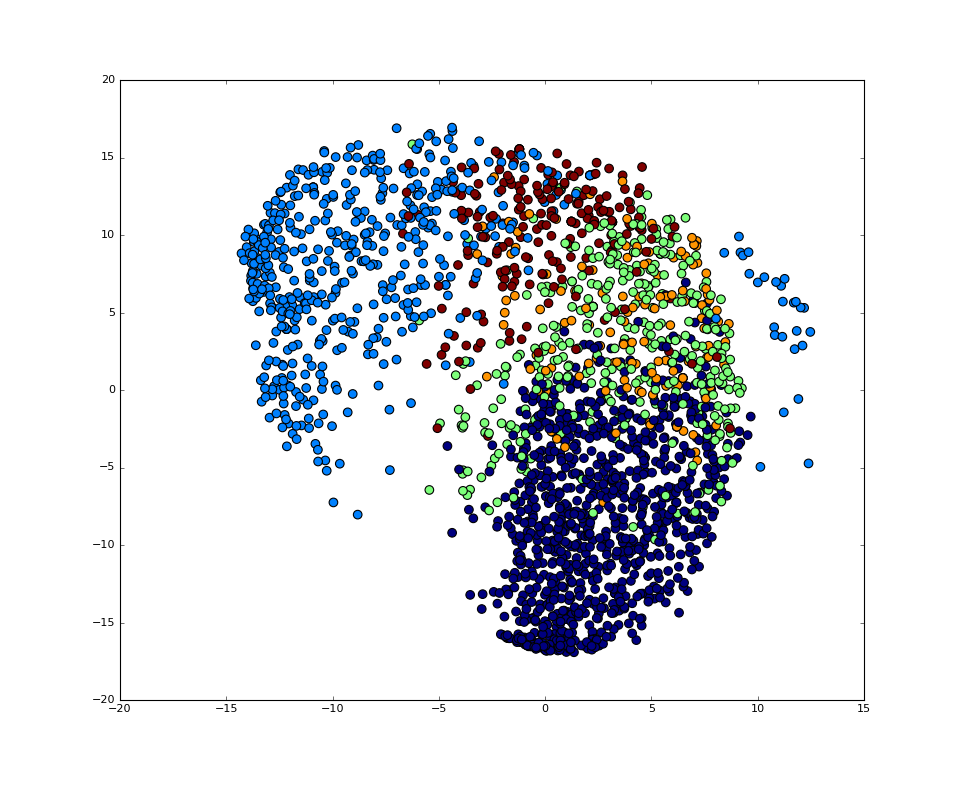

In [13]:
# para debuggear
#
# import sys
# nb_stdout = sys.stdout
# sys.stdout = open('/dev/stdout', 'w')

%matplotlib notebook

import sounddevice as sd
#sd.default.samplerate = SAMPLE_RATE
#sd.default.device = 18

def pointClicked(event):
    fileToPlayData = None
    fileToPlaySampleRate = None
    
    if ( event.xdata == None ):
        return
    
    for i in range(0, positions.shape[0]):
        if dist.euclidean( positions[i,:], np.array( (event.xdata,event.ydata) ) ) < THRESHOLD/8:
            fileToPlay = audioFiles[i]
            fileToPlayData, fileToPlaySampleRate = librosa.core.load(fileToPlay, sr = None)
            #sound = matrixAudioData[i]
            #ound = matrixAudioDataNoFFT[i]
            
    if fileToPlayData != None:
        sd.play(fileToPlayData, fileToPlaySampleRate, blocking = True)

fig = plt.figure(figsize=(12, 10))
plt.scatter(positions[:,0], positions[:,1], s=60, c=cutTree)
fig.canvas.mpl_connect('button_press_event', pointClicked )             
plt.show()

## Export

In [55]:
audioFilesForExport = list( map( lambda x : x[25:], audioFiles ) )
np.savetxt("audioClusteringResult.tsv", 
           np.c_[ positions, cutTree, audioFilesForExport ], 
           fmt = "%s", 
           header = "x\ty\tcluster\tfile",
           delimiter = "\t") 


### Espectrogramas

In [ ]:
%matplotlib inline
import librosa.display

ESPECTROGRAMA_SAVE_TO = "results/espectrogramas/"

for i in range(740, len(audioFiles)):
    fig = plt.figure(figsize=(6, 5))
    y, sr = librosa.load(audioFiles[i], sr = SAMPLE_RATE)
    
    y.resize(ceil(SAMPLE_RATE * SEGUNDOS_FILA))
    
    D = librosa.stft(y)
    librosa.display.specshow(librosa.logamplitude(np.abs(D)**2,
                                               ref_power=np.max),
                          y_axis='log', x_axis='time')
    plt.title('Power spectrogram')
    plt.colorbar(format='%+2.0f dB')
    matplotlib.pyplot.savefig(ESPECTROGRAMA_SAVE_TO + str(i) + ".png", bbox_inches='tight')
    plt.close(fig)